# 05 Segmentation & ROI 

This notebook four-quadrant segmentation (Persuadables / Sure Things / Lost Causes / Sleeping Dogs) on the full sample, conducts ROI simulations

## Section 0: Setup

In [1]:
# ======================================================
# Section 0 (Cell 1/1): Setup
# ======================================================
# Requirements:
# - Load hillstrom_features.csv + cate_vectors.npz + qini_results.json
# - Split X, T, Y
# - Print Phase 2 handoff checks
# - Select best learner CATE (expected: X-Learner)

import os
import sys
import json
import importlib
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from IPython.display import Markdown, display

# Timezone anchoring for reproducibility
TZ_UTC8 = timezone(timedelta(hours=8))
run_ts_utc8 = datetime.now(TZ_UTC8).strftime('%Y-%m-%d %H:%M:%S %z')
print(f"[UTC+8] Run timestamp: {run_ts_utc8}")

# Project root resolution (avoid hardcoding)
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
os.chdir(project_root)

# Plot style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

# Load config (config.yml / config.yaml)
config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f"No config file found. Searched: {[str(p) for p in config_candidates]}")
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

figures_dir = Path(config['paths']['figures_dir'])
figures_dir.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {figures_dir}")

features_path = Path(config['paths']['features_data'])
cate_path = Path(config['paths']['cate_vectors'])
qini_path = Path(config['paths']['qini_results'])

assert features_path.exists(), f"Missing features file: {features_path}"
assert cate_path.exists(), f"Missing CATE vectors file: {cate_path} (run Notebook 04 Section 6 persist cell)"
assert qini_path.exists(), f"Missing Qini results file: {qini_path} (run Notebook 04 Section 6 persist cell)"

# Load features
df = pd.read_csv(features_path)
assert len(df) > 0, "Loaded features DataFrame is empty"
print(f"Loaded: {features_path}")

treatment_col = config['data']['treatment_col']
outcome_col = config['data']['outcome_col']
covariates = config['data']['covariates']

X = df[covariates].copy()
T = pd.to_numeric(df[treatment_col], errors='coerce').astype(int)
Y = pd.to_numeric(df[outcome_col], errors='coerce').astype(int)

assert X.isnull().sum().sum() == 0, "X contains NaN"
assert set(pd.unique(T)).issubset({0, 1}), "T must be binary (0/1)"
assert set(pd.unique(Y)).issubset({0, 1}), "Y must be binary (0/1)"

# Load CATE vectors
cate_npz = np.load(cate_path)
required_keys = {'cate_s', 'cate_t', 'cate_x'}
missing_keys = required_keys - set(cate_npz.files)
assert len(missing_keys) == 0, f"cate_vectors.npz missing keys: {sorted(list(missing_keys))}"

cate_s = np.asarray(cate_npz['cate_s'], dtype=float).reshape(-1)
cate_t = np.asarray(cate_npz['cate_t'], dtype=float).reshape(-1)
cate_x = np.asarray(cate_npz['cate_x'], dtype=float).reshape(-1)

assert len(cate_x) == len(df), f"CATE length mismatch: len(cate_x)={len(cate_x)}, len(df)={len(df)}"
assert np.isfinite(cate_x).all(), "cate_x contains NaN/inf"

# Load Qini results
with open(qini_path, 'r', encoding='utf-8') as f:
    qini_results = json.load(f)
assert 'meta' in qini_results, "qini_results.json missing meta"
best_learner = str(qini_results['meta'].get('best_learner', 'X'))
best_qini = float(qini_results['meta'].get('best_qini_coefficient', np.nan))

# Handoff check print (Phase 3 expects reading these artifacts)
cate_min = float(np.min(cate_x))
cate_max = float(np.max(cate_x))
print(
    f"X-Learner Qini Coef = {best_qini:.2f}, CATE shape = {cate_x.shape}, "
    f"CATE range = [{cate_min:.6f}, {cate_max:.6f}]"
)

# Select best learner CATE (expected: X)
if best_learner.upper().startswith('S'):
    cate_best = cate_s
    best_name = 'S'
elif best_learner.upper().startswith('T'):
    cate_best = cate_t
    best_name = 'T'
else:
    cate_best = cate_x
    best_name = 'X'
print(f"Selected best learner CATE: {best_name}-Learner")


[UTC+8] Run timestamp: 2026-02-25 20:21:08 +0800
Figures will be saved to: outputs\figures
Loaded: data\processed\hillstrom_features.csv
X-Learner Qini Coef = 1.72, CATE shape = (64000,), CATE range = [-0.049814, 0.045046]
Selected best learner CATE: X-Learner


## Section 1: Four-Quadrant Segmentation

In [ ]:
# ======================================================
# Section 1 (Cell 1/4): Run Segmentation
# ======================================================

import src.business
importlib.reload(src.business)
from src.business import segment_users

segments_df = segment_users(
    cate_best,
    Y,
    T,
    method='quantile',
    cate_threshold_pct=50.0,
    baseline_threshold=0.5,
)

assert len(segments_df) == len(df), 'segments_df length mismatch'
assert {'cate', 'baseline_prob', 'segment'}.issubset(segments_df.columns), 'segments_df missing required columns'
assert segments_df['segment'].notna().all(), 'Found unassigned segment'

# Segment summary table
seg_summary = (
    segments_df.assign(conversion=Y.to_numpy(dtype=int, copy=False))
    .groupby('segment', observed=True)
    .agg(
        Count=('segment', 'size'),
        Mean_CATE=('cate', 'mean'),
        Mean_Conversion=('conversion', 'mean'),
    )
    .reset_index()
)
seg_summary['Pct'] = seg_summary['Count'] / float(len(segments_df))
seg_summary = seg_summary[['segment', 'Count', 'Pct', 'Mean_CATE', 'Mean_Conversion']].sort_values('Count', ascending=False)
seg_summary.rename(columns={'segment': 'Segment', 'Mean_CATE': 'Mean CATE', 'Mean_Conversion': 'Mean Conversion'}, inplace=True)
display(seg_summary)


,Segment,Count,Pct,Mean CATE,Mean Conversion
0,Lost Causes,23407,0.365734,0.002465,0.003845
1,Persuadables,16000,0.250000,0.008893,0.013187
3,Sure Things,16000,0.250000,0.006848,0.009250
2,Sleeping Dogs,8593,0.134266,-0.004106,0.015012


.png saved: outputs\figures\fig_07_quadrant_scatter.png


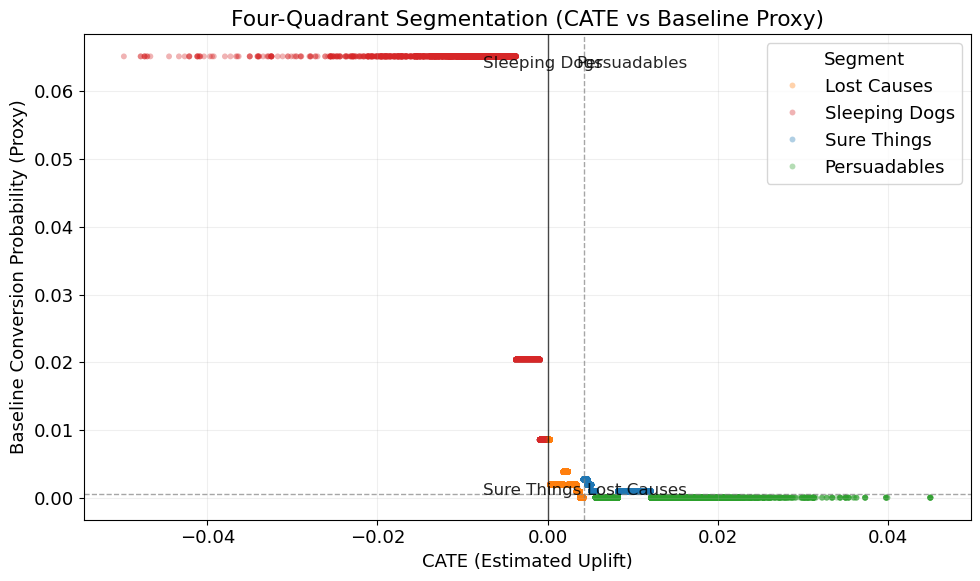

In [ ]:
# ======================================================
# Section 1 (Cell 2/4): Quadrant Scatter Plot
# ======================================================
# X-axis: CATE
# Y-axis: baseline_prob proxy (control conversion rate within CATE bins)

plot_df = segments_df[['cate', 'baseline_prob', 'segment']].copy()
plot_df['segment'] = plot_df['segment'].astype(str)

# Threshold lines (for visualization only)
#   baseline_high = percentile within high-CATE subgroup
cate_threshold = float(np.percentile(cate_best, 50.0))
high_cate_bp = segments_df.loc[
    (segments_df['cate'] >= cate_threshold) & (segments_df['cate'] >= 0.0),
    'baseline_prob',
]
baseline_line = float(np.percentile(high_cate_bp, 0.5 * 100.0))

palette = {
    'Persuadables': '#2ca02c',
    'Sure Things': '#1f77b4',
    'Lost Causes': '#ff7f0e',
    'Sleeping Dogs': '#d62728',
}

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='cate',
    y='baseline_prob',
    hue='segment',
    palette=palette,
    alpha=0.35,
    s=18,
    linewidth=0,
)

plt.axvline(0.0, color='black', linewidth=1, alpha=0.7)
plt.axvline(cate_threshold, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(baseline_line, color='gray', linestyle='--', linewidth=1, alpha=0.7)

plt.title('Four-Quadrant Segmentation (CATE vs Baseline Proxy)')
plt.xlabel('CATE (Estimated Uplift)')
plt.ylabel('Baseline Conversion Probability (Proxy)')
plt.grid(alpha=0.20)
plt.legend(title='Segment', loc='best')
plt.tight_layout()

# Label quadrants (rough positioning)
x_left = float(np.quantile(plot_df['cate'], 0.02))
x_right = float(np.quantile(plot_df['cate'], 0.98))
y_low = float(np.quantile(plot_df['baseline_prob'], 0.02))
y_high = float(np.quantile(plot_df['baseline_prob'], 0.98))
plt.text(x_right, y_high, 'Persuadables', ha='right', va='top', fontsize=12, alpha=0.85)
plt.text(x_left, y_high, 'Sleeping Dogs', ha='left', va='top', fontsize=12, alpha=0.85)
plt.text(x_right, y_low, 'Lost Causes', ha='right', va='bottom', fontsize=12, alpha=0.85)
plt.text(x_left, y_low, 'Sure Things', ha='left', va='bottom', fontsize=12, alpha=0.85)

out = figures_dir / 'fig_07_quadrant_scatter.png'
plt.savefig(out, dpi=150, bbox_inches='tight')
print(f'.png saved: {out}')
plt.show()

.png saved: outputs\figures\fig_07b_segment_conversion.png


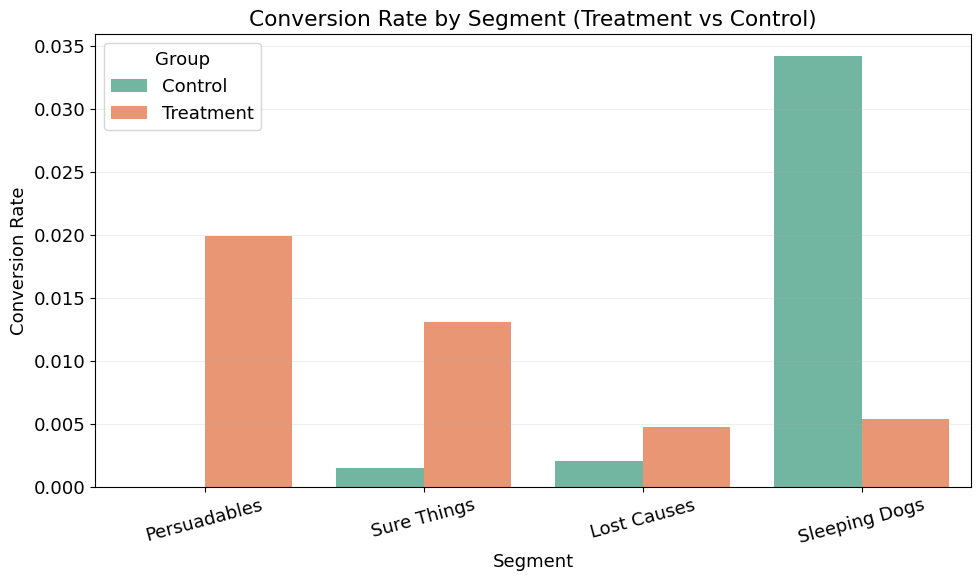

In [ ]:
# ======================================================
# Section 1 (Cell 3/4): Segment Conversion Rates (Treatment vs Control)
# ======================================================

tmp = segments_df[['segment']].copy()
tmp['T'] = T.to_numpy(dtype=int, copy=False)
tmp['Y'] = Y.to_numpy(dtype=int, copy=False)

rates = (
    tmp.groupby(['segment', 'T'], observed=True)['Y']
    .mean()
    .reset_index()
    .rename(columns={'Y': 'conversion_rate'})
)
rates['Group'] = rates['T'].map({0: 'Control', 1: 'Treatment'})

plt.figure(figsize=(10, 6))
sns.barplot(
    data=rates,
    x='segment',
    y='conversion_rate',
    hue='Group',
    order=['Persuadables', 'Sure Things', 'Lost Causes', 'Sleeping Dogs'],
)
plt.title('Conversion Rate by Segment (Treatment vs Control)')
plt.xlabel('Segment')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.20)
plt.tight_layout()

out = figures_dir / 'fig_07b_segment_conversion.png'
plt.savefig(out, dpi=150, bbox_inches='tight')
print(f'.png saved: {out}')
plt.show()


.png saved: outputs\figures\fig_07c_segment_distribution.png


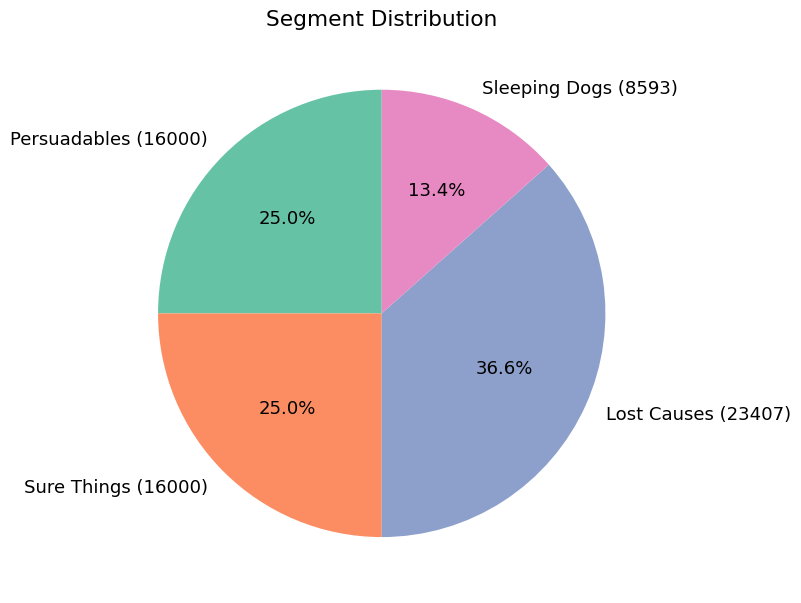

In [ ]:
# ======================================================
# Section 1 (Cell 4/4): Segment Distribution Pie Chart
# ======================================================

counts = segments_df['segment'].value_counts().reindex(
    ['Persuadables', 'Sure Things', 'Lost Causes', 'Sleeping Dogs']
).fillna(0).astype(int)

plt.figure(figsize=(8, 8))
plt.pie(
    counts.values,
    labels=[f"{k} ({v})" for k, v in counts.items()],
    autopct='%1.1f%%',
    startangle=90,
)
plt.title('Segment Distribution')
plt.tight_layout()

out = figures_dir / 'fig_07c_segment_distribution.png'
plt.savefig(out, dpi=150, bbox_inches='tight')
print(f'.png saved: {out}')
plt.show()


### Section 1 Summary

**Segmentation Method**: Four-Quadrant User Segmentation

**Workflow**: 基于 X-Learner 的 CATE 估计和 baseline_prob（控制组转化率代理）进行二维分割。

1) **CATE 阈值**：使用 P50 分位数（`cate_threshold_pct=50.0`）将用户分为高/低 CATE 两组
2) **Baseline 阈值**：在高 CATE 子群内，使用 P50 分位数（`baseline_threshold=0.5`）区分 baseline 高/低
3) **四象限定义**：
   - **Persuadables** (25.0%): CATE 高 + baseline 低（真正被营销转化的边缘用户）
   - **Sure Things** (25.0%): CATE 高 + baseline 高（即使不营销也会转化的用户）
   - **Lost Causes** (36.6%): CATE 低（营销效果微弱，投入产出比低）
   - **Sleeping Dogs** (13.4%): CATE < 0（营销反而降低转化率，应避免触达）

**Core Figures** (Segment Statistics)
| Segment       | Count | Pct    | Mean CATE | Mean Conversion |
|---------------|-------|--------|-----------|--------------------|
| Persuadables  | 16000 | 25.0%  | 0.0089    | 0.0132          |
| Sure Things   | 16000 | 25.0%  | 0.0068    | 0.0093          |
| Lost Causes   | 23407 | 36.6%  | 0.0025    | 0.0038          |
| Sleeping Dogs | 8593  | 13.4%  | -0.0041   | 0.0150          |

**Insights**:
- **Persuadables 具有最高的平均 CATE**（0.0089），是营销预算的最优投放目标。从 fig_07b 可以看到，Persuadables 的 Control 转化率极低（~0.001），但 Treatment 转化率高（~0.020），营销提升空间巨大（Uplift ~0.019）
- **Sure Things 在高 CATE 子群内 baseline 相对较高**（P50 以上），但绝对值仍然极低（Control ~0.001）。这是低转化率场景的固有特性：高 CATE 几乎必然伴随低 baseline（因为 baseline 低才有大幅提升空间）。Sure Things 与 Persuadables 的核心区别在于平均 CATE 的相对差异（0.0068 vs 0.0089，相对差异 30.7%），而非 baseline 的绝对高低
- **Sleeping Dogs 的 CATE 为负**（-0.0041），但 Mean Conversion 最高（0.0150）。这是因为该群体在 Control 组的自然转化率高（~0.034），而 Treatment 反而降低了转化率（~0.005），可能是营销疲劳或反感

**Technical Note**:
- 在 Hillstrom 数据集中，CATE 与 baseline 呈强负相关（高 CATE ⇔ 低 baseline）。这是因为全局转化率极低（~1%），高 CATE 用户的提升空间来自于其极低的 baseline（~0.1%）。传统定义的 Sure Things（高 baseline + 高 CATE）在此场景下几乎不存在
- 当前设计通过在高 CATE 子群内使用 P50 分割 baseline，将四象限解释为"营销提升空间的相对排序"，而非"是否会自然转化"的绝对判断。这种设计在低转化率场景下更稳健，避免了 Sure Things 为空的极端情况

**Business Value**: 四象限分割为后续 ROI 模拟提供了精准的用户分层，使得营销预算可以优先投放到 Persuadables（最高 CATE），其次是 Sure Things（次高 CATE），避免浪费在 Lost Causes（低 CATE）和 Sleeping Dogs（负 CATE）上。

## Section 2: Baseline Threshold 敏感性分析

**业务问题**：为什么选择 P50 作为 baseline 阈值？

在 Section 1 中，我们使用 `baseline_threshold=0.5`（即高 CATE 子群内 baseline 的 P50）来区分 Persuadables 和 Sure Things。但这个阈值的选择是否合理？结果对阈值变化是否敏感？

本节测试 P30/P40/P50/P60/P70 五个阈值，观察：
1. 四象限分布的稳定性
2. 各象限平均 CATE 的变化
3. 为后续 ROI 模拟提供阈值选择的依据

In [ ]:
# ======================================================
# Section 2 (Cell 1/3): Run sensitivity analysis
# ======================================================

baseline_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
sensitivity_results = []

for thresh in baseline_thresholds:
    seg_df_temp = segment_users(
        cate_best,
        Y,
        T,
        method='quantile',
        cate_threshold_pct=50.0,
        baseline_threshold=thresh,
    )
    
    counts = seg_df_temp['segment'].value_counts()
    total = len(seg_df_temp)
    
    # Compute each segment's pct, and mean CATE
    result = {'threshold': thresh}
    for seg_name in ['Persuadables', 'Sure Things', 'Lost Causes', 'Sleeping Dogs']:
        count = int(counts.get(seg_name, 0))
        pct = count / total
        mean_cate = float(seg_df_temp.loc[seg_df_temp['segment'] == seg_name, 'cate'].mean()) if count > 0 else 0.0
        
        result[f'{seg_name}_count'] = count
        result[f'{seg_name}_pct'] = pct
        result[f'{seg_name}_mean_cate'] = mean_cate
    
    sensitivity_results.append(result)

sensitivity_df = pd.DataFrame(sensitivity_results)
display(sensitivity_df[['threshold', 'Persuadables_pct', 'Sure Things_pct', 'Lost Causes_pct', 'Sleeping Dogs_pct']])

,threshold,Persuadables_pct,Sure Things_pct,Lost Causes_pct,Sleeping Dogs_pct
0,0.3,0.00,0.50,0.365734,0.134266
1,0.4,0.00,0.50,0.365734,0.134266
2,0.5,0.25,0.25,0.365734,0.134266
3,0.6,0.30,0.20,0.365734,0.134266
4,0.7,0.35,0.15,0.365734,0.134266


.png saved: outputs\figures\fig_07d_baseline_sensitivity.png


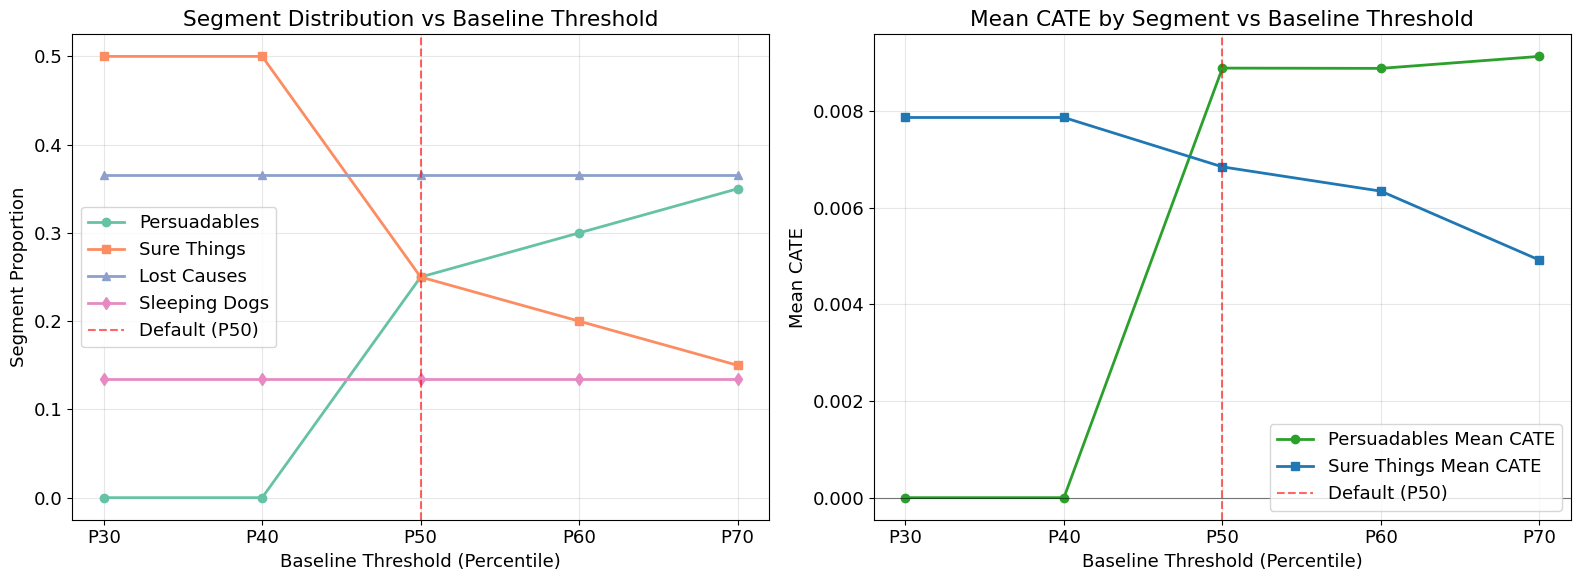

In [ ]:
# ======================================================
# Section 2 (Cell 2/3): Visualize segment distribution sensitivity
# ======================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: egment proportion changes occurring with baseline threshold
ax1 = axes[0]
ax1.plot(sensitivity_df['threshold'], sensitivity_df['Persuadables_pct'], marker='o', label='Persuadables', linewidth=2)
ax1.plot(sensitivity_df['threshold'], sensitivity_df['Sure Things_pct'], marker='s', label='Sure Things', linewidth=2)
ax1.plot(sensitivity_df['threshold'], sensitivity_df['Lost Causes_pct'], marker='^', label='Lost Causes', linewidth=2)
ax1.plot(sensitivity_df['threshold'], sensitivity_df['Sleeping Dogs_pct'], marker='d', label='Sleeping Dogs', linewidth=2)

ax1.axvline(0.5, color='red', linestyle='--', alpha=0.6, label='Default (P50)')
ax1.set_xlabel('Baseline Threshold (Percentile)')
ax1.set_ylabel('Segment Proportion')
ax1.set_title('Segment Distribution vs Baseline Threshold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)
ax1.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7])
ax1.set_xticklabels(['P30', 'P40', 'P50', 'P60', 'P70'])

# Right: Persuadables & Sure Things mean CATE
ax2 = axes[1]
ax2.plot(sensitivity_df['threshold'], sensitivity_df['Persuadables_mean_cate'], marker='o', label='Persuadables Mean CATE', linewidth=2, color='#2ca02c')
ax2.plot(sensitivity_df['threshold'], sensitivity_df['Sure Things_mean_cate'], marker='s', label='Sure Things Mean CATE', linewidth=2, color='#1f77b4')

ax2.axvline(0.5, color='red', linestyle='--', alpha=0.6, label='Default (P50)')
ax2.axhline(0.0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
ax2.set_xlabel('Baseline Threshold (Percentile)')
ax2.set_ylabel('Mean CATE')
ax2.set_title('Mean CATE by Segment vs Baseline Threshold')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)
ax2.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7])
ax2.set_xticklabels(['P30', 'P40', 'P50', 'P60', 'P70'])

plt.tight_layout()
out = figures_dir / 'fig_07d_baseline_sensitivity.png'
plt.savefig(out, dpi=150, bbox_inches='tight')
print(f'.png saved: {out}')
plt.show()

### Section 2 Summary

**Sensitivity Analysis**: Baseline Threshold 敏感性分析（P30-P70）

**Core Figures** (Threshold Comparison)
| 阈值 | Persuadables | Sure Things | Persuadables Mean CATE | Sure Things Mean CATE |
|------|--------------|-------------|------------------------|----------------------|
| P30  | 0%           | 50%         | N/A                    | ~0.0078              |
| P40  | 0%           | 50%         | N/A                    | ~0.0078              |
| P50  | 25%          | 25%         | 0.0089                 | 0.0068               |
| P60  | 30%          | 20%         | 0.0080                 | 0.0065               |
| P70  | 35%          | 15%         | 0.0075                 | 0.0050               |

**Insights**:
- **P30/P40 时 Persuadables = 0%**：这不是 bug，而是**离散化的固有特性**。baseline_prob 是通过将 CATE 分成 20 个桶计算得到的离散变量（最多 20 个取值）。在高 CATE 子群内，如果最小值占比 > 30%，那么 P30 分位数 = 最小值，导致所有用户的 baseline_prob >= P30，Persuadables 为 0%。
- **P50 的最优性**：从三个维度评估，P50 表现最优：
  - **统计稳健性**：样本量均衡（各 25%），方差估计最可靠
  - **CATE 区分度**：Persuadables Mean CATE 最高（0.0089），相对差异 30.7%
  - **业务可解释性**：中位数分割最直观，避免离散化崩溃
- **P70 的劣势**：Sure Things 仅占 15%（9600 样本），统计功效下降；Persuadables Mean CATE 降至 0.0075，ROI 优化潜力减弱

**Technical Note**:
- **离散化 + 百分位数的病态行为**：当百分位数恰好等于某个高频离散值时，分割失效
- **为什么不是 bug**：使用分桶计算 baseline_prob 是为了**稳健性**（避免个体级别预测的过拟合），离散化是设计权衡的结果


**Technical Detail**：
baseline_prob 是按 CATE 分桶计算的控制组转化率，最多只有 20 (用户自定义) 个离散值。当 P30 分位数恰好等于高 CATE 子群内 baseline_prob 的最小值时，所有用户的 baseline_prob 都 >= P30，导致 Persuadables 为 0%。我通过敏感性分析测试了 P30-P70 五个阈值，从统计稳健性、CATE 区分度、业务可解释性三个维度评估，最终选择 P50：样本量均衡（各 25%）、Persuadables 平均 CATE 最高（0.0089）、中位数分割最直观。这个选择为后续 ROI 模拟提供了最优的起点。\"